<a href="https://colab.research.google.com/github/Geethen/Invasive_Species_Mapping/blob/main/example_usuage/end_to_end_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook demonstrates the 8 steps to create and export an invasive tree species image
> #### Input: Reference points (GEE FeatureCollection) containing the classes of interest as a property.
> #### Arguments: A start and end data, cloud threshold, area of interest, image composite interval
> #### Output: Invasive Tree species map

**Step 1**: Install and load modules  
**Step 2**: Prepare time series composite and additional covariates  
**Step 3**: Prepare dataset for model training and evaluation  
**Step 4**: Export data (optional)  
**Step 5**: Fit model  
**Step 6**: Model evaluation  
**Step 7**: Visualize classified image  
**Step 8**: Export classified image  

## Step 1: Install and load modules

In [1]:
%pip install watermark geemap geeml -q
!git clone https://github.com/Geethen/Invasive_Species_Mapping.git
import sys
sys.path.insert(0,'/content/Invasive_Species_Mapping/code')

Note: you may need to restart the kernel to use updated packages.


fatal: destination path 'Invasive_Species_Mapping' already exists and is not an empty directory.


In [1]:
%load_ext watermark
%load_ext autoreload

In [2]:
import ee
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

import geemap

# Add module to environment varibles
import sys
MODULE_FULL_PATH = r'C:\Users\coach\myfiles\postdoc\code\Invasive_Species_Mapping\code'
sys.path.insert(1, MODULE_FULL_PATH)
from typing import Union

# Load python modules with preprocessing functions. 
from timeSeriesFunctions import prepareTS
from covariateFunctions import prepareCovariates
from trainDataFunctions import prepareTrainingData
from modelFitFunctions import prepareModel
from metricFunctions import prepareMetrics
from conformalClassifier import conformalFeatureClassifier
from geeml.utils import eeprint

In [3]:
%watermark -v -m --iversions

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit

geemap: 0.29.5
sys   : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:50:36) [MSC v.1929 64 bit (AMD64)]
ee    : 0.2



In [4]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## Step 2: Prepare time series composite

### Prepare Sentinel-2 Data

In [6]:
# start and end dates for time series
Date_Start = ee.Date('2017-01-01')
Date_End = ee.Date('2017-12-31')

# how many days to summarise in each image e.g 30 days = 12 images per year
day_int = 31 #step size

# cloud probabillity threshold
CLOUD_THRESH=30

# which bands to keep
BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6','B7', 'B8', 'B8A', 'B9', 'B11','B12', 'ndvi','ndwi','ndre','nbr','evi']

# Import reference points
points = ee.FeatureCollection("projects/ee-geethensingh/assets/aliens_sep2018")
# Create AOI - bounds of aoi
aoi = points.geometry().bounds()

# flatten imagecollection to image - each image becomes a band
s2TS = prepareTS(Date_Start,Date_End,day_int,aoi,CLOUD_THRESH,BANDS)\
.timeSeries(satellite = 'S2', s2_level = 1)

# Add additional terrain related covariates
X = prepareCovariates(proj = 'EPSG:4326', covariates = s2TS, nAngles = 10).addCovariates(rotatedCoords = True, topoBands =True)
X.bandNames()

In [6]:
# Plot aoi and ndvi- check if data overlap
Map.centerObject(aoi, 8)
Map.addLayer(X.select('band0_ndvi'), {}, 'Jan ndvi')
Map.addLayer(aoi)

## Step 3: Prepare dataset for model training and evaluation

### Add additional covariates and extract covariates to points.

In this notebook, the reference points (shapefile) is already uploaded to Google Earth Engine (GEE). However, if you need to upload your shapefile to GEE you could either [manually upload it](https://developers.google.com/earth-engine/guides/table_upload) or you could upload it by using the geeup package. An example can be found [here](https://github.com/Geethen/Invasive_Species_Mapping/blob/main/example_usuage/geeup_Simple_CLI_for_Earth_Engine_Uploads.ipynb).

#### Extract covariates at points
Sentinel time series information is extracted for all points

In [5]:
# name of the label property
label = 'class'    

FOLDS = 10

# Extract covariate image values to points
pTrainData = prepareTrainingData(covariates = X, points = points, targetProperty = label, nFolds = FOLDS, proj =  'EPSG:4326')
dataset = pTrainData.covariatesToPoints()
# dataset.limit(1)

## Step 5: Fit model

### Fit a random forest model using Kfold cross validation. Each fold is one spatial cluster (clustering on x and y coordinates)

In [6]:
# load DATA (if exported earlier)
# train = ee.FeatureCollection('users/geethensingh/trainData')
# X = ee.Image('users/geethensingh/inferenceImage')

bandnames = X.bandNames()
# number of classes
NCLASS = dataset.aggregate_histogram(label).size()

In [10]:
# number of folds for kfold
FOLDS = 10  
# fit k-fold classifiers
# apply function and train kfold classifieres
test = prepareModel(dataset = train, responseCol = label, inferenceImage = X, bandNames = bandnames)

NameError: name 'train' is not defined

In [7]:
# Fit randomforest model with multiprobability output
def train_test_split(data: ee.FeatureCollection, split: float, seed: int)-> Union[ee.FeatureCollection, ee.FeatureCollection]:
            """Function to split a dataset into two portions based on train portion (split). Results in 
               a near stratified sample. There is statistical error associated with random.
            
            Args
                split (float): train proportion. Will not return exact number of samples
                
            Returns
                train (ee.FeatureCollection), test (ee.FeatureCollection) """
            
            ## define fraction for training (remainder is for testing)
            data = data.randomColumn(seed= seed)
            ## divide into training and testing sets based on the split
            training = data.filter(ee.Filter.lt('random', split))
            calibration = data.filter(ee.Filter.gte('random', split))
            return training, calibration
        
train, remainder = train_test_split(data = dataset, split = 0.7, seed = 42)

#train and apply classifier
classifier = ee.Classifier.smileRandomForest(**{
    'numberOfTrees':100
}).setOutputMode('MULTIPROBABILITY')\
.train(**{
    'features': train,
    'classProperty':label,
    'inputProperties': bandnames
})
classified = remainder.classify(classifier).select(['classification', label])

## Create a study area map

In [9]:
import pandas as pd
import geopandas as gpd
import geemap
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.ticker import FuncFormatter

polygon_data=aoi.getInfo()

# Extract coordinates
coordinates = polygon_data['coordinates'][0]

# Create a Shapely Polygon
polygon = Polygon(coordinates)

# Create a GeoDataFrame with the polygon
geometry = [polygon]
region = gpd.GeoDataFrame(geometry=geometry)

# Load the South Africa map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter South Africa
south_africa = world[world['name'] == 'South Africa']

In [88]:
# Load a shapefile for a specific region within South Africa
# Replace 'path_to_shapefile' with the actual path to your shapefile

calibration, test = train_test_split(data = remainder, split = 0.5, seed = 42)
train = ee.data.computeFeatures({
    'expression': train,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
test = ee.data.computeFeatures({
    'expression': test,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
calibration = ee.data.computeFeatures({
    'expression': calibration,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
region.crs = 'EPSG:4326'
train.crs = 'EPSG:4326'
test.crs = 'EPSG:4326'
calibration.crs = 'EPSG:4326'
calibration['Cal'] = 'Calibration'
test['Cal'] = 'Test'
train['Cal'] = 'Train'

points = pd.concat([train, test, calibration], ignore_index=True)

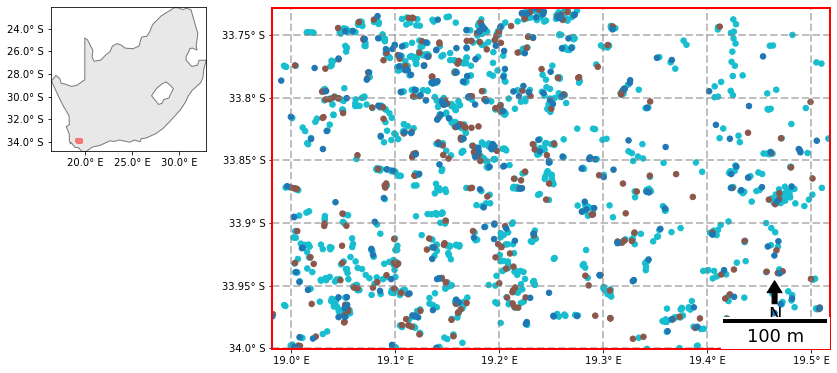

In [59]:
# Create the main map with zoomed region and colored points
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the South Africa map
south_africa.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot the region with colored points
region.plot(ax=ax, color='white', edgecolor='blue')
points.plot(ax=ax, column='Cal', markersize=30, legend=False)

# Set plot limits to focus on the specified region
minx, miny, maxx, maxy = region.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
# Customize axis lines to be red
ax.spines['bottom'].set_color('red')
ax.spines['top'].set_color('red')
ax.spines['left'].set_color('red')
ax.spines['right'].set_color('red')
# Set the thickness of the axis lines
ax.spines['top'].set_linewidth(2.0)
ax.spines['bottom'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)

# Create the inset map for South Africa on top left
ax_inset = fig.add_axes([-0.2, 0.55, 0.25, 0.25])  # Adjust the coordinates and size as needed
south_africa.plot(ax=ax_inset, color='lightgrey', edgecolor='black', alpha =0.5)
region.plot(ax=ax_inset, color='white', edgecolor='red', alpha =0.5, linewidth=3)
ax_inset.xaxis.set_major_formatter(FuncFormatter(lambda x, _: format_lat(x, _)))
ax_inset.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_lon(y, _)))

# Set inset map limits
inset_minx, inset_miny, inset_maxx, inset_maxy = south_africa.total_bounds
ax_inset.set_xlim(inset_minx, inset_maxx)
ax_inset.set_ylim(inset_miny, inset_maxy)

# Add a scale bar
scalebar = ScaleBar(1, location='lower right', units='km')
scalebar.font_properties.set_size(18)  # Set the font size
ax.add_artist(scalebar)

# Add North Arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=18,
            xycoords=ax.transAxes)

# add gridlines and coords
ax.grid(True,linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Format the x and y axes with latitude and longitude
def format_lon(value, pos):
    direction = 'N' if value >= 0 else 'S'
    return f'{abs(value)}° {direction}'
def format_lat(value, pos):
    direction = 'E' if value >= 0 else 'W'
    return f'{abs(value)}° {direction}'

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: format_lat(round(x, 3), _)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_lon(round(y, 3), _)))

# plt.show()
# Save the map to an image file (e.g., PNG)
plt.savefig(r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\IS_sampleDistt.png', bbox_inches='tight', pad_inches=0.1, dpi=350, transparent=True)


In [9]:
# Function to convert list property to individual properties
def convert_list_to_properties(feature):
    values_list = ee.List(feature.getArray('classification').toList())
    
    # Create a sequence of indices
    indices = ee.List.sequence(0, values_list.length().subtract(1)) \
        .map(lambda val: ee.Algorithms.String(ee.Number(val).int()))
    
    dictionary = ee.Dictionary.fromLists(indices, values_list)
    
    return feature.set(dictionary)

# Apply the function to the feature collection
bands = ['0','1','2','3','4','5','6','7','8','9','10']
updated_features = classified.map(lambda ft: convert_list_to_properties(ft)).select(ee.List(bands).add(label))


### Uncertainty Quantification

We show two methods for using conformal prediction.
1) Extracting the model, and data and performing UQ using MAPIE and
2) Using Earth Engine API to perform UQ. This approach uses the conformalFeatureClassifier methods

The input data (data argument) required are points (ee.FeatureCollection), with properties that include,
1) a reference property (name of this property is provided to label argument)
2) For each output class, a probability-like score from the classifier. This can be obtained using the MultiProbability output

The bands input (bands argument) is a list of band names. One for each output class.

### Method 1 - GEE native

In [13]:
dwl = ee.ImageCollection('projects/nina/GIS_synergy/Extent/DW_global_validation_tiles');
dwLabels = dwl\
  .select([1], ['label'])\
  .map(lambda img: #remove unmarked up areas and extra-class
    ee.Image(img.updateMask(img.gt(0).And(img.lt(10))).subtract(1).copyProperties(img))\
    .set('joinindex', img.rename(img.getString('system:index')).regexpRename('^[^_]*_', '').bandNames().getString(0))
  )
  
dwp = ee.ImageCollection("projects/ee-geethensingh/assets/UQ/DW_probs");
dwp = dwp.map(lambda img: #//rename bands, mask 0 pixels
    ee.Image(img.rename(bands).selfMask()).copyProperties(img)
    # hacky method to edit image property
    .set('joinindex', img.select([0]).rename(img.getString('id_no')).regexpRename('^[^_]*_', '').bandNames().getString(0))
  )
  
# Join label collection and probability collection on their 'joinindex' property.
# The propertyName parameter is the name of the property
# that references the joined image.
def indexJoin(collectionA, collectionB, propertyName):
    joined =  ee.ImageCollection(ee.Join.saveFirst(propertyName).apply(**{
    'primary': collectionA,
    'secondary': collectionB,
    'condition': ee.Filter.equals(**{
      'leftField': 'joinindex',
      'rightField': 'joinindex'})
  }))
# Merge the bands of the joined image.
    return joined.map(lambda image:image.addBands(ee.Image(image.get(propertyName))))

dwCombined = indexJoin(dwLabels, dwp, 'probImage')

# Get a stratified sample of each of 9 classes using the label band.
data = ee.Image(dwCombined.first())

# Sample 100 points per class. some classes have less than
# 100 pixels, so there will be less than 900 points
points = ee.FeatureCollection(data
.stratifiedSample(**{'numPoints':100, 'classBand':'label', 'region':data.geometry(100),
'scale':10, 'seed':42, 'geometries': True})).randomColumn(**{'seed': 42})#add random column
eeprint(points)


EEException: Collection.first: Error in map(ID=probs_dw_-0p5169602165_51p4043077942-20170409):
Image.rename: The number of names (11) must match the number of bands (9).

In [34]:
# Load python modules with preprocessing functions.
%autoreload 2
bands = ['water', 'trees', 'grass', 'flooded_vegetation',
'crops', 'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']
# Calibrate conformal predictor
CP = conformalFeatureClassifier(data = points, bands = bands, alpha = 0.1, split = 0.8, label = 'label', version = 'aliens_19112023')
qHat = CP.calibrate().get('qHat')
qHat


In [35]:
CP.evaluate()

Average set size: 3.45
Empirical (marginal) coverage: 0.91


## Calibrate and evaluate conformal predictor

In [11]:
# Load python modules with preprocessing functions.
%autoreload 2

bands = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
# Calibrate conformal predictor
CP = conformalFeatureClassifier(data = updated_features, bands = bands, alpha = 0.1, split = 0.8, label = label, version = 'aliens_19112023')
# Calibrate conformal predictor based on provided settings
CP.calibrate()
# Evaluate confromal predictor on (out-of-sample) test set
CP.evaluate()


Average set size: 1.53
Empirical (marginal) coverage: 0.92


In [12]:
# Generate a probability band for each class
probImage = X.classify(classifier).arrayFlatten([bands])
# Create sets for each image
uncertainty = CP.predict(probImage)
uncertainty

In [95]:
classDict = {"0": "Bare_Ground", "1": "Black_Wattle", "2": "Dense_Pines", "3": "Fynbos_High_Density", "4": "Fynbos_Low_Density", "5": "Gum", "6": "Indigenous_Forest", "7": "Rock", "8": "Wetland","9": "Snow", "10": "Water"}
uncertainty = uncertainty.rename(list(classDict.values())+['setLength'])
uncertainty

NameError: name 'uncertainty' is not defined

In [43]:
BaseImage(sl).download(
    r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\IASSetLength10m.png', region=aoi, crs='EPSG:4326', scale=10,
    dtype='uint16', max_tile_size=2, max_tile_dim = 50, overwrite=True,)

IASSetLength10m.png: |          | 0.00/36.1M (raw) [  0.0%] in 00:00 (eta:     ?)

In [38]:
export_params2 = {
    'image': uncertainty,
    'description': 'export_uncertaintyImage',
    'assetId': 'projects/ee-geethensingh/assets/UQ/IAS_UQImage',
    'scale': 10,
    'region': aoi,
    'maxPixels': 1e9
}

# Export the data to the Earth Engine asset
task1 = ee.batch.Export.image.toAsset(**export_params2)
task1.start()

# create a MaskedImage from the earth engine asset
# medoid_asset_im = gd.MaskedImage.from_id(medoid_asset_id)
# download asset image
# medoid_asset_im.download('s2_medoid_im.tif', overwrite=True)

In [40]:
task1.status()

{'state': 'RUNNING',
 'description': 'export_uncertaintyImage',
 'creation_timestamp_ms': 1701789263082,
 'update_timestamp_ms': 1701789337353,
 'start_timestamp_ms': 1701789270839,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'C3XRGX2T6ZAJ5QTUNJLUQ24P',
 'name': 'projects/earthengine-legacy/operations/C3XRGX2T6ZAJ5QTUNJLUQ24P'}

In [15]:
#train and apply classifier
classifier = ee.Classifier.smileRandomForest(**{
    'numberOfTrees':100
}).train(**{
    'features': train,
    'classProperty':label,
    'inputProperties': bandnames
})

classDict = {"0": "Bare_Ground", "1": "Black_Wattle", "2": "Dense_Pines", "3": "Fynbos_High_Density", "4": "Fynbos_Low_Density", "5": "Gum", "6": "Indigenous_Forest", "7": "Rock", "8": "Wetland","9": "Snow", "10": "Water"}
bands = list(classDict.values())
classified = X.classify(classifier)

export_params2 = {
    'image': classified,
    'description': 'export_classificationImage',
    'assetId': 'projects/ee-geethensingh/assets/UQ/IAS_ClsImage',
    'scale': 10,
    'region': aoi,
    'maxPixels': 1e9
}

# Export the data to the Earth Engine asset
task = ee.batch.Export.image.toAsset(**export_params2)
task.start()

In [18]:
task.status()

{'state': 'COMPLETED',
 'description': 'export_classificationImage',
 'creation_timestamp_ms': 1701863362809,
 'update_timestamp_ms': 1701864121685,
 'start_timestamp_ms': 1701863367808,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://code.earthengine.google.com/?asset=projects/ee-geethensingh/assets/UQ/IAS_ClsImage'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 28276.451171875,
 'id': '4EEVFJQ4Z2BMZEOZNVIZJ3WZ',
 'name': 'projects/earthengine-legacy/operations/4EEVFJQ4Z2BMZEOZNVIZJ3WZ'}

In [4]:
classified = ee.Image("projects/ee-geethensingh/assets/UQ/IAS_ClsImage")
Map = geemap.Map()
# '472c01','e1f506','c8dd3c','47b369','026b23','bec387','43fa7d','724929','0781e6','07e2e6','1c357a'
Map.addLayer(classified ,{'min':0, 'max':10, 'palette':['472c01','e1f506','c8dd3c','47b369','026b23','bec387','43fa7d','724929','0781e6','07e2e6','1c357a']}, 'Classification')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [7]:
Map.layer_to_image('Classification', output=r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\IASCls10m.png', crs='EPSG:3857', region= aoi, scale=10)


IASCls10m.png.tif: |          | 0.00/65.2M (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


In [ ]:
uncertainty = ee.Image('projects/ee-geethensingh/assets/UQ/IAS_UQImage')

Map.addLayer(uncertainty,{'min':0, 'max':11},'Uncertainty')
Map

In [8]:
# Add uncertainty image to map
vis_params = {'bands': ['setLength'], 'palette': ['#440154', ' #440256', ' #450457', ' #450559', ' #46075a', ' #46085c', ' #460a5d', ' #460b5e', ' #470d60', ' #470e61', ' #471063', ' #471164', ' #471365', ' #481467', ' #481668', ' #481769', ' #48186a', ' #481a6c', ' #481b6d', ' #481c6e', ' #481d6f', ' #481f70', ' #482071', ' #482173', ' #482374', ' #482475', ' #482576', ' #482677', ' #482878', ' #482979', ' #472a7a', ' #472c7a', ' #472d7b', ' #472e7c', ' #472f7d', ' #46307e', ' #46327e', ' #46337f', ' #463480', ' #453581', ' #453781', ' #453882', ' #443983', ' #443a83', ' #443b84', ' #433d84', ' #433e85', ' #423f85', ' #424086', ' #424186', ' #414287', ' #414487', ' #404588', ' #404688', ' #3f4788', ' #3f4889', ' #3e4989', ' #3e4a89', ' #3e4c8a', ' #3d4d8a', ' #3d4e8a', ' #3c4f8a', ' #3c508b', ' #3b518b', ' #3b528b', ' #3a538b', ' #3a548c', ' #39558c', ' #39568c', ' #38588c', ' #38598c', ' #375a8c', ' #375b8d', ' #365c8d', ' #365d8d', ' #355e8d', ' #355f8d', ' #34608d', ' #34618d', ' #33628d', ' #33638d', ' #32648e', ' #32658e', ' #31668e', ' #31678e', ' #31688e', ' #30698e', ' #306a8e', ' #2f6b8e', ' #2f6c8e', ' #2e6d8e', ' #2e6e8e', ' #2e6f8e', ' #2d708e', ' #2d718e', ' #2c718e', ' #2c728e', ' #2c738e', ' #2b748e', ' #2b758e', ' #2a768e', ' #2a778e', ' #2a788e', ' #29798e', ' #297a8e', ' #297b8e', ' #287c8e', ' #287d8e', ' #277e8e', ' #277f8e', ' #27808e', ' #26818e', ' #26828e', ' #26828e', ' #25838e', ' #25848e', ' #25858e', ' #24868e', ' #24878e', ' #23888e', ' #23898e', ' #238a8d', ' #228b8d', ' #228c8d', ' #228d8d', ' #218e8d', ' #218f8d', ' #21908d', ' #21918c', ' #20928c', ' #20928c', ' #20938c', ' #1f948c', ' #1f958b', ' #1f968b', ' #1f978b', ' #1f988b', ' #1f998a', ' #1f9a8a', ' #1e9b8a', ' #1e9c89', ' #1e9d89', ' #1f9e89', ' #1f9f88', ' #1fa088', ' #1fa188', ' #1fa187', ' #1fa287', ' #20a386', ' #20a486', ' #21a585', ' #21a685', ' #22a785', ' #22a884', ' #23a983', ' #24aa83', ' #25ab82', ' #25ac82', ' #26ad81', ' #27ad81', ' #28ae80', ' #29af7f', ' #2ab07f', ' #2cb17e', ' #2db27d', ' #2eb37c', ' #2fb47c', ' #31b57b', ' #32b67a', ' #34b679', ' #35b779', ' #37b878', ' #38b977', ' #3aba76', ' #3bbb75', ' #3dbc74', ' #3fbc73', ' #40bd72', ' #42be71', ' #44bf70', ' #46c06f', ' #48c16e', ' #4ac16d', ' #4cc26c', ' #4ec36b', ' #50c46a', ' #52c569', ' #54c568', ' #56c667', ' #58c765', ' #5ac864', ' #5cc863', ' #5ec962', ' #60ca60', ' #63cb5f', ' #65cb5e', ' #67cc5c', ' #69cd5b', ' #6ccd5a', ' #6ece58', ' #70cf57', ' #73d056', ' #75d054', ' #77d153', ' #7ad151', ' #7cd250', ' #7fd34e', ' #81d34d', ' #84d44b', ' #86d549', ' #89d548', ' #8bd646', ' #8ed645', ' #90d743', ' #93d741', ' #95d840', ' #98d83e', ' #9bd93c', ' #9dd93b', ' #a0da39', ' #a2da37', ' #a5db36', ' #a8db34', ' #aadc32', ' #addc30', ' #b0dd2f', ' #b2dd2d', ' #b5de2b', ' #b8de29', ' #bade28', ' #bddf26', ' #c0df25', ' #c2df23', ' #c5e021', ' #c8e020', ' #cae11f', ' #cde11d', ' #d0e11c', ' #d2e21b', ' #d5e21a', ' #d8e219', ' #dae319', ' #dde318', ' #dfe318', ' #e2e418', ' #e5e419', ' #e7e419', ' #eae51a', ' #ece51b', ' #efe51c', ' #f1e51d', ' #f4e61e', ' #f6e620', ' #f8e621', ' #fbe723', ' #fde725'], 'min': 1.0, 'max': 3.0, 'opacity': 1.0}

Map.layer_to_image('Uncertainty', output=r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\IAS10m.png', crs='EPSG:3857', region= aoi, scale=10)

# Download uncertainty map to disk
# geemap.download_ee_image(uncertainty.select('setLength'), r"C:\Users\coach\myfiles\postdoc\Uncertainty\data\output\IAS_uncertaintySL.tif", crs = 'EPSG:4326', region = aoi, scale=10)

IAS10m.png.tif: |          | 0.00/65.2M (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


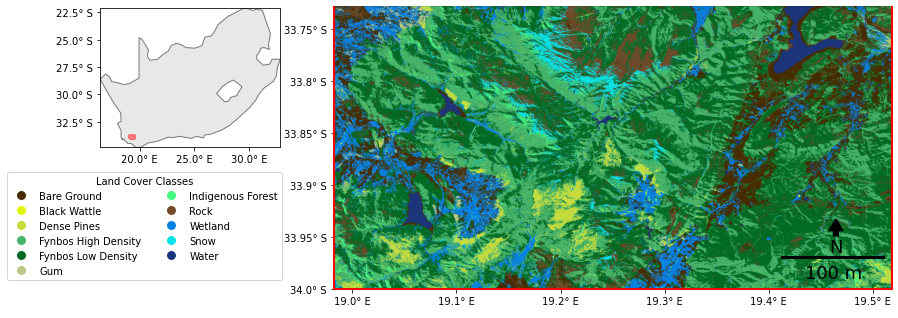

In [43]:
import matplotlib.pyplot as plt
import matplotlib.colorbar as cbar
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib.image import imread, imsave
# Create the main map with zoomed region and colored points
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the South Africa map
south_africa.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot the region with colored points
region.plot(ax=ax, color='white', edgecolor='blue')
# points.plot(ax=ax, column='Cal', markersize=30, legend=False)

# Set plot limits to focus on the specified region
minx, miny, maxx, maxy = region.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
# Customize axis lines to be red
ax.spines['bottom'].set_color('red')
ax.spines['top'].set_color('red')
ax.spines['left'].set_color('red')
ax.spines['right'].set_color('red')
# Set the thickness of the axis lines
ax.spines['top'].set_linewidth(2.0)
ax.spines['bottom'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)

# Create the inset map for South Africa on top left
ax_inset = fig.add_axes([-0.2, 0.50, 0.25, 0.25])  # Adjust the coordinates and size as needed
south_africa.plot(ax=ax_inset, color='lightgrey', edgecolor='black', alpha =0.5)
region.plot(ax=ax_inset, color='white', edgecolor='red', alpha =0.5, linewidth=3)
ax_inset.xaxis.set_major_formatter(FuncFormatter(lambda x, _: format_lat(x, _)))
ax_inset.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_lon(y, _)))

# Set inset map limits
inset_minx, inset_miny, inset_maxx, inset_maxy = south_africa.total_bounds
ax_inset.set_xlim(inset_minx, inset_maxx)
ax_inset.set_ylim(inset_miny, inset_maxy)

# add gridlines and coords
# ax.grid(True,linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Format the x and y axes with latitude and longitude
def format_lon(value, pos):
    direction = 'N' if value >= 0 else 'S'
    return f'{abs(value)}° {direction}'
def format_lat(value, pos):
    direction = 'E' if value >= 0 else 'W'
    return f'{abs(value)}° {direction}'

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: format_lat(round(x, 3), _)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_lon(round(y, 3), _)))

# Read the PNG image from disk
image_path = r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\IASCls10m.png'
image = imread(image_path)

# Plot the image
# Plot the PNG image in the AOI
aoi_ax = fig.add_axes([0.127, 0.164, 0.772, 0.68])  # Adjust the coordinates and size as needed
aoi_ax.imshow(image,  extent=(minx, maxx, miny,maxy),alpha=1)  # Adjust alpha as needed
aoi_ax.axis('off')  # Turn off the axes

# Add a scale bar
scalebar = ScaleBar(1, location='lower right', units='km', frameon=False, pad=0.5)
scalebar.font_properties.set_size(18)  # Set the font size
aoi_ax.add_artist(scalebar)

# Add North Arrow
x, y, arrow_length = 0.9, 0.25, 0.1
aoi_ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=18,
            xycoords=ax.transAxes)

# Add legend
cax = fig.add_axes([-0.19, 0.22, 0.25, 0.25])
cax.axis("off")
# Create a dictionary for mapping values to colors
color_dict = {'0': '472c01', '1': 'e1f506', '2': 'c8dd3c', '3': '47b369', '4': '026b23',
              '5': 'bec387', '6': '43fa7d', '7': '724929', '8': '0781e6', '9': '07e2e6', '10': '1c357a'}

# Create a dictionary for mapping values to labels
label_dict = {"0": "Bare Ground", "1": "Black Wattle", "2": "Dense Pines", "3": "Fynbos High Density",
              "4": "Fynbos Low Density", "5": "Gum", "6": "Indigenous Forest", "7": "Rock", "8": "Wetland",
              "9": "Snow", "10": "Water"}

# Create a legend with categorical values and colors
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label_dict[key],
                              markerfacecolor='#' + color_dict[key], markersize=10) for key in color_dict.keys()]

# Add the legend to the main map
cax.legend(handles=legend_elements, loc='upper right', title='Land Cover Classes', ncol=2)

# plt.show()
plt.savefig(r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\IAS_cls.svg', bbox_inches='tight', pad_inches=0.1, dpi=350, transparent=True)


In [50]:
# Plot the second image
# Read the PNG image from disk
image_path = r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\IAS10m.png'
image2 = imread(image_path)

# Plot the image
# Plot the PNG image in the AOI
fig, ax = plt.subplots()
ax.imshow(image2,  extent=(minx, maxx, miny,maxy),alpha=1)  # Adjust alpha as needed
ax.axis('off')  # Turn off the axes

# Add a color bar
cax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # Adjust the position and size as needed
norm = Normalize(vmin=1, vmax=3)  # Normalize based on the image values
color_map = cm.viridis  # You can choose a different colormap if needed
cb = cbar.ColorbarBase(cax, cmap=color_map, norm=norm)
cb.set_label('Uncertainty', rotation=270, labelpad=15, fontsize=16)  # Add colorbar title
cb.ax.tick_params(labelsize=16)  # Adjust the fontsize of tick labels as needed
cb.ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# plt.show()

# Save the modified image with the color bar
output_path = r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\IAS_UQ10m.svg'
fig.savefig(output_path, bbox_inches='tight', pad_inches=0.1, dpi = 350)
plt.close()

In [54]:
classified = ee.Image("projects/ee-geethensingh/assets/UQ/IAS_ClsImage")
uncertainty = ee.Image("projects/ee-geethensingh/assets/UQ/IAS_UQImage")

Map = geemap.Map()
Map.addLayer(classified, {'min':0, 'max':10, 'palette':['#472c01', '#0a0907', '#696662', '#47b369', '#026b23', '#fcfffd', '#43fa7d', '#403f23', '#0781e6', '#07e2e6','#1c357a']}, 'Classification')

# All sets containing pine
pine = uncertainty.select('Dense_Pines')
Map.addLayer(pine, {'min':0, 'max':1, 'palette':['000000', 'c8dd3c']}, 'All sets with pine')

# All sets with only pine
# Get sets with length 1
setLength = uncertainty.select('setLength').eq(1)
Map.addLayer(pine.updateMask(setLength).unmask(0), {'min':0, 'max':1,'palette':['000000', 'c8dd3c']}, 'Pine only')
Map

Map.layer_to_image('All sets with pine', output=r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\PineSets10m.png', crs='EPSG:3857', region= aoi, scale=10)
Map.layer_to_image('Pine only', output=r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\PineOnlySets10m.png', crs='EPSG:3857', region= aoi, scale=10)


PineSets10m.png.tif: |          | 0.00/65.2M (raw) [  0.0%] in 00:00 (eta:     ?)

PineOnlySEts10m.png.tif: |          | 0.00/65.2M (raw) [  0.0%] in 00:00 (eta:     ?)

In [72]:
# Create and save pine sets figure
# Plot the second image
# Read the PNG image from disk
image_path = r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\PineSets10m.png'
image2 = imread(image_path)

# Plot the image
# Plot the PNG image in the AOI
fig, ax = plt.subplots()
ax.imshow(image2,  extent=(minx, maxx, miny,maxy),alpha=1)  # Adjust alpha as needed
ax.axis('off')  # Turn off the axes

# Add legend
cax = fig.add_axes([0.88, 0.3, 0.02, 0.5])
cax.axis("off")
# Create a dictionary for mapping values to colors
color_dict = {'0': '000000', '1': 'c8dd3c'}

# Create a dictionary for mapping values to labels
label_dict = {"0": "Other", "1": "All sets that include the class Dense pine"}

# Create a legend with categorical values and colors
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label_dict[key],
                              markerfacecolor='#' + color_dict[key], markersize=10, alpha=1) for key in color_dict.keys()]

# Add the legend to the main map
legend = cax.legend(handles=legend_elements, loc='upper right', ncol=1, framealpha=0.5)
for text in legend.get_texts():
    text.set_fontsize(11)  # Adjust the font size as needed

# plt.show()

# Save the modified image with the color bar
output_path = r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\PineSets10m.svg'
fig.savefig(output_path, bbox_inches='tight', pad_inches=0.1, dpi = 350)
plt.close()

In [74]:
# Create and save pine sets figure
# Plot the second image
# Read the PNG image from disk
image_path = r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\PineOnlySets10m.png'
image2 = imread(image_path)

# Plot the image
# Plot the PNG image in the AOI
fig, ax = plt.subplots()
ax.imshow(image2,  extent=(minx, maxx, miny,maxy),alpha=1)  # Adjust alpha as needed
ax.axis('off')  # Turn off the axes

# Add legend
cax = fig.add_axes([0.88, 0.3, 0.02, 0.5])
cax.axis("off")
# Create a dictionary for mapping values to colors
color_dict = {'0': '000000', '1': 'c8dd3c'}

# Create a dictionary for mapping values to labels
label_dict = {"0": "Other", "1": "Pine-only sets"}

# Create a legend with categorical values and colors
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label_dict[key],
                              markerfacecolor='#' + color_dict[key], markersize=10, alpha=1) for key in color_dict.keys()]

# Add the legend to the main map
legend = cax.legend(handles=legend_elements, loc='upper right', ncol=1, framealpha=0.5)
for text in legend.get_texts():
    text.set_fontsize(11)  # Adjust the font size as needed

# plt.show()

# Save the modified image with the color bar
output_path = r'C:\Users\coach\myfiles\postdoc\Uncertainty\figures\PineOnlySets10m.svg'
fig.savefig(output_path, bbox_inches='tight', pad_inches=0.1, dpi = 350)
plt.close()

In [102]:
X_train = train[X.bandNames().getInfo()]
y_train = train[['class']].values.ravel()
X_test = test[X.bandNames().getInfo()]
y_test = test[['class']].values.ravel()
X_calibration = calibration[X.bandNames().getInfo()]
y_calibration = calibration[['class']].values.ravel()

In [103]:
from sklearn.ensemble import RandomForestClassifier
from mapie.classification import MapieClassifier
# Fit model on training data
model = RandomForestClassifier().fit(X_train, y_train)
# Fit MAPIE on calibration data
# Important: calibration data must be different from training data!
mapie = MapieClassifier(estimator=model, cv="prefit", method = 'lac'
  ).fit(X_calibration, y_calibration)

In [105]:
from mapie.metrics import classification_coverage_score
from mapie.metrics import classification_mean_width_score
import numpy as np

y_pred, y_set = mapie.predict(X_test, alpha=0.1)
y_set = np.squeeze(y_set)

cov = classification_coverage_score(y_test, y_set)
setsize = classification_mean_width_score(y_set)
print('Coverage: {:.2%}'.format(cov))
print("Avg. set size: {:.2f}".format(setsize))

Coverage: 90.19%
Avg. set size: 1.37


In [16]:
from geedim.download import BaseImage
file = r'D:\inference.tif'
BaseImage(test.inferenceImage).download(file, crs= 'EPSG:4326', region = study_area1,
                                                 scale = 10, overwrite=True, num_threads=20)

Consider adjusting `region`, `scale` and/or `dtype` to reduce the inference.tif download size (raw: 86.43 GB).


inference.tif: |          | 0.00/86.4G (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


In [23]:
%autoreload 2
model = test.calibratedClassifier

In [11]:
from mapie.classification import MapieClassifier

# Initialize the Conformal Prediction classifier
X_cal, y_cal = test.calibrationData
rf = test.fittedClassifier
confPredictor = MapieClassifier(estimator=rf, cv="prefit", method="raps")
confPredictor.fit(X_cal, y_cal)

MapieClassifier(cv='prefit',
                estimator=RandomForestClassifier(max_features=20,
                                                 n_estimators=50, n_jobs=-1,
                                                 random_state=0),
                method='raps')

In [12]:
import rasterio
import pandas as pd
import rasterio
from rasterio.plot import reshape_as_image
import numpy as np

# Specify the path to your TIFF file
tif_file = r'D:\inference.tif'

# Define the subset window (in pixel coordinates)
# The window is defined as (row_start, row_stop), (col_start, col_stop)
subset_window = ((0, 32), (0, 32))

# Open the TIFF file
with rasterio.open(tif_file) as src:
    # Read the subset of the raster data using the defined window
    src_array = src.read(window=subset_window)
    # print(src.crs)

    # format into pandas df
    # src_array = src.read(window=window)
    i_arr = reshape_as_image(src_array)

    # Save the window image as a new TIFF file
    output_tif_file = r'C:\Users\coach\myfiles\postdoc\Uncertainty\scratch\window_image.tif'
    with rasterio.open(output_tif_file, 'w', driver='GTiff', width=i_arr.shape[1], height=i_arr.shape[0],
                    count=i_arr.shape[2], dtype=i_arr.dtype, crs = src.crs) as dst:
        dst.write(src_array)

    print("Window image has been saved as:", output_tif_file)

    #Format input_image for inference
    nPixels = i_arr.shape[0]*i_arr.shape[1]
    nBands = i_arr.shape[-1]
    # Take full image and reshape into long 2d array (nrow * ncol, nband) for classification
    new_arr = i_arr.reshape(nPixels, nBands)#reshape 3d array to 2d array that matches the training data table from earlier
    bandnames = list(src.descriptions)
    data = pd.DataFrame(new_arr, columns = bandnames).fillna(0)
    mapie_prob_preds = model.predict_proba(data)
    mapie_prob_preds = mapie_prob_preds[~np.isnan(mapie_prob_preds)]
    y_pred_score, y_ps_score = confPredictor.predict(data, alpha = 0.1)
    # # Reshape our classification map back into a 2D matrix so we can save it as an image
    labels = y_pred_score.reshape(i_arr[:, :, 0].shape).astype(np.float64)
    probs = mapie_prob_preds.reshape(i_arr[:, :, 0].shape).astype(np.float64)
    sets = y_ps_score.reshape([i_arr.shape[0],i_arr.shape[1], rf.n_classes_]).astype(np.float64)


RasterioIOError: D:/inference.tif: No such file or directory

In [17]:
infile = r'C:\Users\coach\myfiles\postdoc\Uncertainty\scratch\window_image.tif'
outfile = r'C:\Users\coach\myfiles\postdoc\Uncertainty\scratch\pred_window_labels.tif'
%autoreload 2

test.inference(mode = 'predict', infile = infile, model = model, confModel= confPredictor, outfile = outfile, patchSize = 16, num_workers = 10)

pred_window_labels.tif:   0%|          | 0/4 [00:00<?, ?it/s]

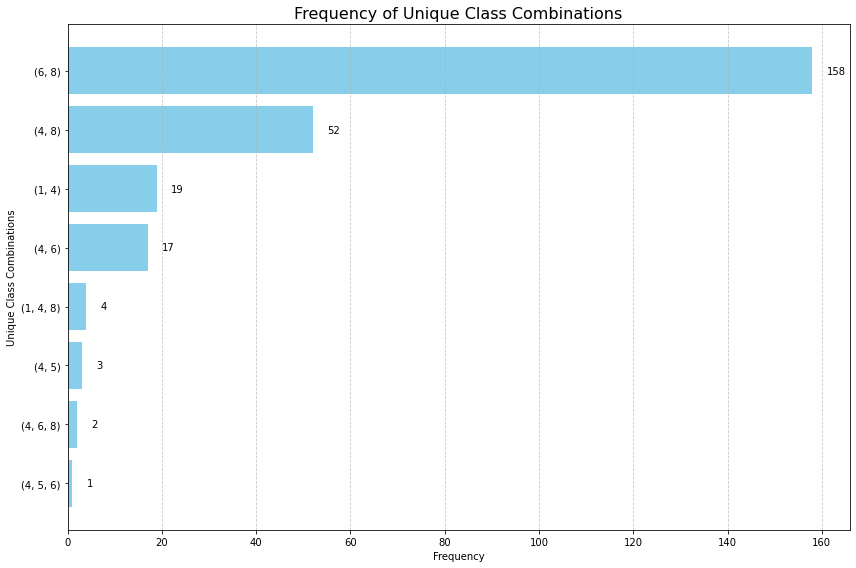

In [138]:
unique_class_combinations = []  # List to store unique class combinations
combination_frequencies = {}  # Dictionary to store combination frequencies

for i in range(result_.shape[0]):
    classes = model.classes_
    mask = y_ps_score[i, :, 0]
    inverted_mask = ~mask
    class_combination = tuple(classes[mask].tolist())

    if class_combination not in unique_class_combinations:
        unique_class_combinations.append(class_combination)
    combination_frequencies[class_combination] = combination_frequencies.get(class_combination, 0) + 1

# Sort unique_class_combinations and frequencies in descending order of frequencies
sorted_indices = np.argsort(frequencies)[::-1]
sorted_unique_class_combinations = [unique_class_combinations[i] for i in sorted_indices]
sorted_frequencies = [frequencies[i] for i in sorted_indices]

# Plotting the frequency distribution
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(sorted_unique_class_combinations)), sorted_frequencies, color='skyblue')
plt.yticks(range(len(sorted_unique_class_combinations)), [str(combination) for combination in sorted_unique_class_combinations])
plt.xlabel('Frequency')
plt.ylabel('Unique Class Combinations')
plt.title('Frequency of Unique Class Combinations', fontsize=16)
plt.gca().invert_yaxis()  # Invert the y-axis to show the combinations from top to bottom
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add the frequency count on top of each bar
for bar, frequency in zip(bars, sorted_frequencies):
    plt.text(bar.get_width() +3 , bar.get_y() + bar.get_height() / 2, str(frequency), ha='left', va='center')

plt.tight_layout()
plt.show()

In [125]:
import numpy as np
for i in range(0,result_.shape[0]):
    classes = model.classes_
    mask = y_ps_score[i,:, 0]
    mx = np.ma.masked_array(classes, mask= ~mask, fill_value = 0)
    remaining_length = np.count_nonzero(~mx.mask)
    print(mx)
    print(remaining_length)

[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[1 -- -- 4 -- -- -- -- --]
2
[1 -- -- 4 -- -- -- -- --]
2
[-- -- -- 4 5 -- -- -- --]
2
[-- -- -- 4 5 -- -- -- --]
2
[-- -- -- 4 5 -- -- -- --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- 4 -- -- -- 8 --]
2
[-- -- -- 4 5 6 -- -- --]
3
[-- -- -- 4 -- 6 -- -- --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- -- 6 -- 8 --]
2
[-- -- -- -- --

In [8]:
# fit k-fold classifiers
# apply function and train kfold classifieres
result = prepareModel(dataset = train, responseCol = label, inferenceImage = X, bandNames = bandnames).kFoldCV(10)
result

## Step 6: Model evaluation

### Compute average accuracy and summed confusion matrix for all folds

In [9]:
modeClassImage = prepareMetrics(classImage = result, nClasses = NCLASS, nFolds = FOLDS).confusionMatrix()
modeClassImage

The average weighted accuracy is [0.7054208273894437] across 10 folds


## Step 7: Visualise clasiified Image

In [ ]:
legend_dict = {
    "Wattle": "00FF00",
    "Bracken": "008000",
    "Eucalyptus": "808080",
    "Forest": "800080",
    "Grassland": "FF00FF",
    "Mixed Woody Grassland": "00FFFF",
    "None Vegetated Features": "FFFF00",
    "Pines": "000080",
    "Recently Cleared Plantations/Young Pines": "800000"
}

palette = ['00FF00',# Wattle-Lime
          '008000', #Bracken-Green
          '808080', #Eucalyptus-Grey
          '800080', #Forest-Purple
          'FF00FF', #Grassland-Pink
          '00FFFF', #Mixed Woody Grassland-Aqua
          'FFFF00', #None Vegetated Features-Yellow
          '000080', #Pines-Navy
          '800000'] #(Recently Cleared Plantations/Young Pines)-Maroon (DarkBrown)

vis_params = {
    'min': 0,
    'max': 8,
    'palette': palette,
}

Map = geemap.Map()
Map.centerObject(study_area1, 8)
Map.addLayer(modeClassImage, vis_params, 'Classified Image')
Map.add_legend(legend_dict = legend_dict)
Map

Map(center=[-24.76509915990505, 30.807101743053455], controls=(WidgetControl(options=['position', 'transparent…

## Step 8: Export classified image (optional)

In [ ]:
# export results
export_params3 = {
    'image': modeClassImage,
    'description': 'export_classImage',
    'assetId': 'users/geethensingh/classImage',
    'scale': 10,
    'region': study_area1
}

# Export the data to the Earth Engine asset
ee.batch.Export.image.toAsset(**export_params3).start()